In [1]:
import numpy as np
import scipy as sp
import os
import time
from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc, rcParams
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os, sys

import random

In [2]:
scale = 1.
W = 6* scale
r = 0.75

if scale != 1.:
    fonts = 21
    ms = 10
else:
    fonts = 18
    ms = 7

rcParams.update({'figure.figsize': (W, W*r),   # 4:3 aspect ratio
                 'font.size' : fonts* scale,      # Set font size to 11pt
                 'axes.labelsize': fonts* scale,  # -> axis labels
                 'xtick.direction':'in',       # xticks
                 'xtick.top': True,
                 'xtick.major.size': 6 * scale,
                 'xtick.major.width': 1 * scale,
                 'xtick.minor.visible': True,
                 'xtick.minor.size': 3 * scale,
                 'xtick.minor.width': 1 * scale,
                 'xtick.major.pad': 5.5 * scale,
                 'ytick.direction':'in',       # yticks
                 'ytick.right': True,
                 'ytick.major.size': 6 * scale,
                 'ytick.major.width': 1 * scale,
                 'ytick.minor.visible': True,
                 'ytick.minor.size': 3 * scale,
                 'ytick.minor.width': 1 * scale,
                 'ytick.major.pad': 5 * scale,
                 'legend.fontsize': fonts* scale, # -> legends
                 'legend.frameon': False,
                 'lines.markersize':ms* scale,
                 'lines.markerfacecolor':'none',
                 'lines.linewidth':1.*scale,
                 'errorbar.capsize':3.*scale,
                 'font.family': 'lmodern',
                 'text.usetex': True,
                 'text.latex.preamble': (      # LaTeX preamble
                     r'\usepackage{lmodern}'
                     # ... more packages if needed
                 ),
                })

ls_ = ['-','-.','--',':']
a_ = [1,0.8,0.6,0.4]

rbm_c = '#0072B2'
rbm_c2 = '#D55E00'
rbm_c3 = '#009E73'

# Marchenko - Pasture distribution

In [3]:
project_name = "TSmodel"
print(project_name)

plot_dir= "../images/" + project_name + "/"
os.system("mkdir -p "+plot_dir)

data_dir= "../data/" + project_name + "/"
model_dir_n = "../data/" + project_name + "/ns/"
model_dir_lr = "../data/" + project_name + "/lr/"
model_dir_bs = "../data/" + project_name + "/bs/"

data_list_n = os.listdir(model_dir_n)
data_list_lr = os.listdir(model_dir_lr)
data_list_bs = os.listdir(model_dir_bs)

models_n = [x for x in data_list_n if os.path.isdir(os.path.join(model_dir_n, x))]
models_lr = [x for x in data_list_lr if os.path.isdir(os.path.join(model_dir_lr, x))]
models_bs = [x for x in data_list_bs if os.path.isdir(os.path.join(model_dir_bs, x))]

ns = [float(x.split('n')[1].split('bs')[0]) for x in models_n]
lrs = [float(x.split('lr')[1].split('n')[0]) for x in models_lr]
bss = [int(x.split('bs')[1]) for x in models_bs]

idx_n = np.argsort(ns)
idx_lr = np.argsort(lrs)
idx_bs = np.argsort(bss)

ns = np.array(ns)[idx_n]
lrs = np.array(lrs)[idx_lr]
bss = np.array(bss)[idx_bs]

print(ns)
print(lrs)
print(bss)

models_n = np.array(models_n)[idx_n]
models_lr = np.array(models_lr)[idx_lr]
models_bs = np.array(models_bs)[idx_bs]
print(models_n)
print(models_lr)
print(models_bs)

fixed_noise = 0.1
fixed_lr = 0.1
fixed_bs = 16

TSmodel
[0.05 0.06 0.07 0.08 0.09 0.1 ]
[0.1 0.2 0.3 0.4 0.5]
[ 4  8 16 32 64]
['TSmodel_lr0.1n0.05bs16' 'TSmodel_lr0.1n0.06bs16'
 'TSmodel_lr0.1n0.07bs16' 'TSmodel_lr0.1n0.08bs16'
 'TSmodel_lr0.1n0.09bs16' 'TSmodel_lr0.1n0.1bs16']
['TSmodel_lr0.1n0.1bs16' 'TSmodel_lr0.2n0.1bs16' 'TSmodel_lr0.3n0.1bs16'
 'TSmodel_lr0.4n0.1bs16' 'TSmodel_lr0.5n0.1bs16']
['TSmodel_lr0.1n0.1bs4' 'TSmodel_lr0.1n0.1bs8' 'TSmodel_lr0.1n0.1bs16'
 'TSmodel_lr0.1n0.1bs32' 'TSmodel_lr0.1n0.1bs64']


In [4]:
load_data = True
if load_data:
    full_data = np.load(data_dir+"data.npz")
    print("Data loaded from ",data_dir+"data.npz")

Data loaded from  ../data/TSmodel/data.npz


# Define target kernel

In [5]:
m = 2.
dim_x = 2

D_t = np.array([2,2])

D_t = np.sort(D_t)
print('d:',D_t)
print(len(D_t)**2)
eig_phi = D_t[::-1]
print(eig_phi)

d: [2 2]
4
[2 2]


In [6]:
data_name_n = []
for n in models_n:
    data_name_n.append(model_dir_n + n + '/' + n + '.npz')
print(data_name_n)

['../data/TSmodel/ns/TSmodel_lr0.1n0.05bs16/TSmodel_lr0.1n0.05bs16.npz', '../data/TSmodel/ns/TSmodel_lr0.1n0.06bs16/TSmodel_lr0.1n0.06bs16.npz', '../data/TSmodel/ns/TSmodel_lr0.1n0.07bs16/TSmodel_lr0.1n0.07bs16.npz', '../data/TSmodel/ns/TSmodel_lr0.1n0.08bs16/TSmodel_lr0.1n0.08bs16.npz', '../data/TSmodel/ns/TSmodel_lr0.1n0.09bs16/TSmodel_lr0.1n0.09bs16.npz', '../data/TSmodel/ns/TSmodel_lr0.1n0.1bs16/TSmodel_lr0.1n0.1bs16.npz']


In [7]:
data_name_lr = []
for n in models_lr:
    data_name_lr.append(model_dir_lr + n + '/' + n + '.npz')
print(data_name_lr)

['../data/TSmodel/lr/TSmodel_lr0.1n0.1bs16/TSmodel_lr0.1n0.1bs16.npz', '../data/TSmodel/lr/TSmodel_lr0.2n0.1bs16/TSmodel_lr0.2n0.1bs16.npz', '../data/TSmodel/lr/TSmodel_lr0.3n0.1bs16/TSmodel_lr0.3n0.1bs16.npz', '../data/TSmodel/lr/TSmodel_lr0.4n0.1bs16/TSmodel_lr0.4n0.1bs16.npz', '../data/TSmodel/lr/TSmodel_lr0.5n0.1bs16/TSmodel_lr0.5n0.1bs16.npz']


In [8]:
data_name_bs = []
for n in models_bs:
    data_name_bs.append(model_dir_bs + n + '/' + n + '.npz')
print(data_name_bs)

['../data/TSmodel/bs/TSmodel_lr0.1n0.1bs4/TSmodel_lr0.1n0.1bs4.npz', '../data/TSmodel/bs/TSmodel_lr0.1n0.1bs8/TSmodel_lr0.1n0.1bs8.npz', '../data/TSmodel/bs/TSmodel_lr0.1n0.1bs16/TSmodel_lr0.1n0.1bs16.npz', '../data/TSmodel/bs/TSmodel_lr0.1n0.1bs32/TSmodel_lr0.1n0.1bs32.npz', '../data/TSmodel/bs/TSmodel_lr0.1n0.1bs64/TSmodel_lr0.1n0.1bs64.npz']


In [9]:
res_n = []
called_n = []
for d in data_name_n:
    try:
        res_n.append(np.load(d))
        called_n.append(d)
    except:
        continue

In [10]:
res_lr = []
called_lr = []
for d in data_name_lr:
    try:
        res_lr.append(np.load(d))
        called_lr.append(d)
    except:
        continue

In [11]:
res_bs = []
called_bs = []
for d in data_name_bs:
    try:
        res_bs.append(np.load(d))
        called_bs.append(d)
    except:
        continue

In [12]:
epochs = res_n[0]['epochs'].item()
batch_size = fixed_bs
save_int = 2
n_seed = 3000

# Freedman–Diaconis rule

Freedman, D., Diaconis, P. On the histogram as a density estimator:L 2 theory. Z. Wahrscheinlichkeitstheorie verw Gebiete 57, 453–476 (1981). https://doi.org/10.1007/BF01025868

\begin{align}
\text{Bin width} = 2 \frac{IQR(x)}{\sqrt[3]{n}} 
\end{align}

Where $IQR$ is interquartile range.

In [13]:
def f_bin(y):
    n = len(y)
    Q1, Q3 = np.percentile(y, [25, 75])
    IQR = Q3 - Q1
    bw = 2.*IQR/np.cbrt(n)
    n_bin = int((max(y) - min(y))//bw)
    return n_bin, (min(y), max(y))

In [14]:
if load_data:
    eig_hist_n = full_data['ns']
    print(eig_hist_n.shape)
else:
    eig_hist_n = np.empty((len(ns), n_seed, epochs//save_int+1, dim_x))
    for n in range(len(ns)):
        print(n)
        for s in range(n_seed):
            for i in range(epochs//save_int+1):
                _, xi, _ = np.linalg.svd(res_n[n]['W'][s][i])
                eig_hist_n[n][s][i] = xi.copy()

(6, 3000, 6, 2)


In [15]:
if load_data:
    eig_hist_lr = full_data['lr']
    print(eig_hist_lr.shape)
else:
    eig_hist_lr = np.empty((len(lrs), n_seed, epochs//save_int+1, dim_x))
    for lr in range(len(lrs)):
        print(lr)
        for s in range(n_seed):
            for i in range(epochs//save_int+1):
                _, xi, _ = np.linalg.svd(res_lr[lr]['W'][s][i])
                eig_hist_lr[lr][s][i] = xi.copy()

(5, 3000, 6, 2)


In [16]:
if load_data:
    eig_hist_bs = full_data['bs']
    print(eig_hist_bs.shape)
else:
    eig_hist_bs = np.empty((len(bss), n_seed, epochs//save_int+1, dim_x))
    for bs in range(len(bss)):
        print(bs)
        for s in range(n_seed):
            for i in range(epochs//save_int+1):
                _, xi, _ = np.linalg.svd(res_bs[bs]['W'][s][i])
                eig_hist_bs[bs][s][i] = xi.copy()

(5, 3000, 6, 2)


In [17]:
for i in range(len(res_n)):
    print(res_n[i]['W'].shape)

(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)


In [18]:
for i in range(len(res_lr)):
    print(res_lr[i]['W'].shape)

(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)


In [19]:
for i in range(len(res_bs)):
    print(res_bs[i]['W'].shape)

(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)
(3000, 6, 2, 2)


In [20]:
dw2_n = np.empty((len(ns),n_seed))
for i in range(len(res_n)):
    dw2_n[i] = np.mean(res_n[i]['grad'][:,-1].reshape(n_seed, -1)**2, axis=1)

In [21]:
dw2_lr = np.empty((len(lrs),n_seed))
for i in range(len(res_lr)):
    dw2_lr[i] = np.mean(res_lr[i]['grad'][:,-1].reshape(n_seed, -1)**2, axis=1)

In [22]:
dw2_bs = np.empty((len(bss),n_seed))
for i in range(len(res_bs)):
    dw2_bs[i] = np.mean(res_bs[i]['grad'][:,-1].reshape(n_seed, -1)**2, axis=1)

In [23]:
dw2_n.shape
dw2_avg_n = np.mean(dw2_n, axis=1)
dw2_std_n = np.std(dw2_n, axis=1)
print(dw2_avg_n)
print(dw2_std_n)

[1.04518588e-33 1.02565600e-33 1.05647474e-33 1.00829578e-33
 1.06229437e-33 1.07975609e-33]
[1.04509674e-33 1.02920505e-33 1.06028920e-33 9.85438581e-34
 1.07165584e-33 1.13579401e-33]


In [24]:
dw2_lr.shape
dw2_avg_lr = np.mean(dw2_lr, axis=1)
dw2_std_lr = np.std(dw2_lr, axis=1)
print(dw2_avg_lr)
print(dw2_std_lr)

[1.07975609e-33 2.56056446e-34 1.11957104e-34 6.41213344e-35
 4.09984680e-35]
[1.13579401e-33 2.56003748e-34 1.14886980e-34 6.45821105e-35
 4.02152561e-35]


In [25]:
dw2_bs.shape
dw2_avg_bs = np.mean(dw2_bs, axis=1)
dw2_std_bs = np.std(dw2_bs, axis=1)
print(dw2_avg_bs)
print(dw2_std_bs)

[1.05730938e-33 1.02908500e-33 1.07975609e-33 1.03669963e-33
 9.90059054e-34]
[1.11843818e-33 1.03300146e-33 1.13579401e-33 1.03492111e-33
 9.93087501e-34]


# Wignor

In [26]:
num_split = np.max([1, (dim_x-1)//2])

if num_split == 1:
    finflag = (0, dim_x, 2)
else:
    finflag = (1, dim_x-2, 2)

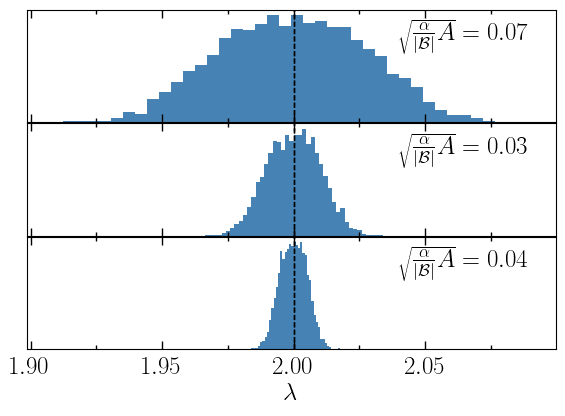

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

for i in eig_phi:
    ax1.axvline(i, ls='--', color='k')

if finflag[0] != 0:
    y = eig_hist_lr[-1,:,-1,0]
    n_bins, xran = f_bin(y)    
    ax1.hist(y, bins=n_bins, range=xran,
             color='steelblue', 
             label=r'$\sqrt{\alpha \varepsilon^2} = %.2f$'%(np.sqrt(lrs[-1]*ns[-1]**2)))

    y = eig_hist_lr[-1,:,-1,-1]
    n_bins, xran = f_bin(y)
    ax1.hist(y, bins=n_bins, range=xran,
             color='steelblue')

for i in range(finflag[0], finflag[1], 2):
    y = eig_hist_lr[-1,:,-1, i:i+2].flatten()
    n_bins, xran = f_bin(y) 
    ax1.hist(y, bins=n_bins, range=xran,
             color='steelblue')
    
# Lower plot
for i in eig_phi:
    ax3.axvline(i, ls='--', color='k')

if finflag[0] != 0:
    y = eig_hist_n[0,:,-1,0]
    n_bins, xran = f_bin(y)    
    ax3.hist(y, bins=n_bins, range=xran,
             color='steelblue')

    y = eig_hist_n[0,:,-1,-1]
    n_bins, xran = f_bin(y)
    ax3.hist(y, bins=n_bins, range=xran,
             color='steelblue')

for i in range(finflag[0], finflag[1], 2):
    y = eig_hist_n[0,:,-1, i:i+2].flatten()
    n_bins, xran = f_bin(y) 
    ax3.hist(y, bins=n_bins, range=xran,
             color='steelblue')

for i in eig_phi:
    ax2.axvline(i, ls='--', color='k')

if finflag[0] != 0:
    y = eig_hist_lr[0,:,-1,0]
    n_bins, xran = f_bin(y)    
    ax2.hist(y, bins=n_bins, range=xran,
             color='steelblue')

    y = eig_hist_lr[0,:,-1,-1]
    n_bins, xran = f_bin(y)
    ax2.hist(y, bins=n_bins, range=xran,
             color='steelblue')

for i in range(finflag[0], finflag[1], 2):
    y = eig_hist_lr[0,:,-1, i:i+2].flatten()
    n_bins, xran = f_bin(y) 
    ax2.hist(y, bins=n_bins, range=xran,
             color='steelblue')

ax1.text(0.95, 0.9,
         r"$\sqrt{\frac{\alpha}{|\mathcal{B}|} A} = %.2f$"%(np.sqrt(lrs[-1]*ns[-1]**2)),
         transform=ax1.transAxes,
         horizontalalignment='right', verticalalignment='top')

ax1.set_yticks([],[])

ax3.text(0.95, 0.9, 
         r"$\sqrt{\frac{\alpha}{|\mathcal{B}|} A}= %.2f$"%(np.sqrt(lrs[-1]*ns[0]**2)),
         transform=ax3.transAxes,
         horizontalalignment='right', verticalalignment='top')

ax3.set_yticks([],[])

ax2.text(0.95, 0.9, 
         r"$\sqrt{\frac{\alpha}{|\mathcal{B}|} A} = %.2f$"%(np.sqrt(lrs[0]*ns[-1]**2)),
         transform=ax2.transAxes,
         horizontalalignment='right', verticalalignment='top')

ax2.set_yticks([],[])

plt.xlabel(r'$\lambda$')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.01)
plt.savefig(plot_dir+'lbd_comp_all3.pdf')

plt.show()

2.0000169946080253
noise: 0.05 s: 0.007426588575131634
2.0000904117729394
noise: 0.06 s: 0.008823382005311213
1.9999610415854299
noise: 0.07 s: 0.010384592475421056
2.0000643296401956
noise: 0.08 s: 0.011177534755735935
2.0001247439474734
noise: 0.09 s: 0.012701952248979286
1.999983340068698
noise: 0.1 s: 0.014340433572383505


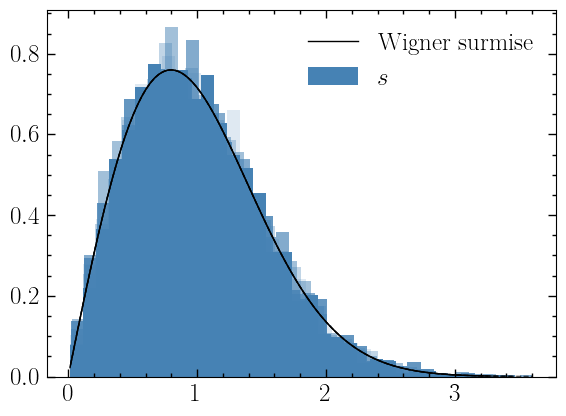

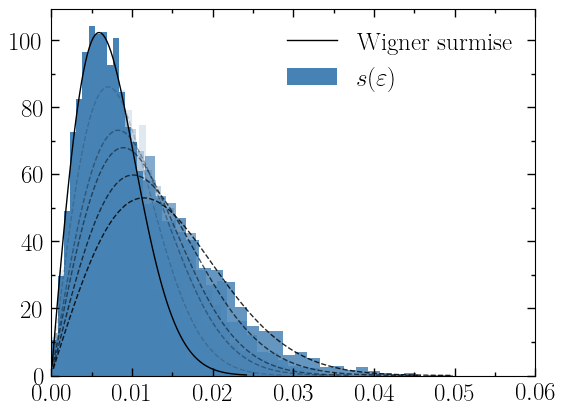

In [28]:
# Wigner surmise

n_d = len(eig_hist_n)
dx_wig_n = np.empty((n_d, num_split))
dx2_wig_n = np.empty((n_d, num_split))

for i in range(n_d):
    for idx in range(finflag[0], finflag[1], finflag[2]):
        lbd_ens = eig_hist_n[i,:,-1, idx:idx+2]
        print(np.mean(lbd_ens))
        
        ##
        s_ens2 = np.abs(lbd_ens[:,0] - lbd_ens[:,1])**2

        y = s_ens2
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean2 = np.sum(px * hb)/np.sum(hb)
        dx2_wig_n[i][idx//2] = s_mean2
        ##

        s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

        y = s_ens
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean = np.sum(px * hb)/np.sum(hb)
        dx_wig_n[i][idx//2] = s_mean
        print('noise:',ns[i], 's:',s_mean)

        yp = y / s_mean

        n_bins, xran = f_bin(yp)
        x = np.linspace(xran[0], xran[1], 100)

        def wigner(x):
            return 0.5*np.pi*x*np.exp(-np.pi * 0.25 * (x)**2)

        if i == 0:
            plt.plot(x, wigner(x), c='k', label=r'Wigner surmise')
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue',
                     label=r'$s$')
        else:
            plt.plot(x, wigner(x), c='k', ls='--', alpha=i/n_d)
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue', alpha=i/n_d)
    
plt.legend()
    
plt.tight_layout()

plt.savefig(plot_dir+'wigner_n.pdf')
plt.show()

# Wigner surmise

for i in range(len(eig_hist_n)):
    for idx in range(finflag[0], finflag[1], finflag[2]):
        lbd_ens = eig_hist_n[i,:,-1,idx:idx+2]

        s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

        y = s_ens
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean = np.sum(px * hb)/np.sum(hb)

        yp = y

        def wigner(x):
            return 0.5*np.pi*(x/s_mean**2)*np.exp(-np.pi * 0.25 * (x/s_mean)**2)

        n_bins, xran = f_bin(yp)
        x = np.linspace(xran[0], xran[1], 100)

        if i == 0:
            plt.plot(x, wigner(x), c='k', ls='-', label=r'Wigner surmise')
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue',
                     label=r'$s(\varepsilon)$')
        else:
            plt.plot(x, wigner(x), c='k', ls='--', alpha=i/n_d)
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue', alpha=i/n_d)

        plt.xlim(0,0.06)
    
plt.legend()

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
    
plt.tight_layout()

plt.savefig(plot_dir+'wigner_unscaled_n.pdf')
plt.show()

2.0 2
lr: 0.1 s: 0.014340433572383505
2.0 2
lr: 0.2 s: 0.02054234056373459
2.0 2
lr: 0.3 s: 0.03015697867050146
2.0 2
lr: 0.4 s: 0.030576189038285604
2.0 2
lr: 0.5 s: 0.04054354611177138


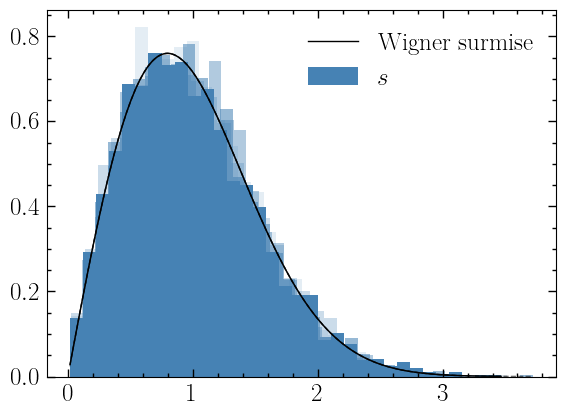

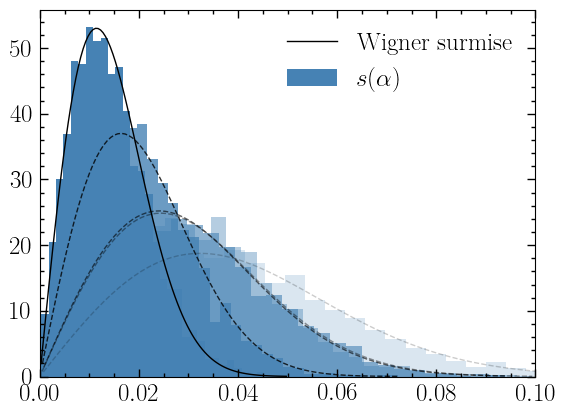

In [29]:
# Wigner surmise

n_d = len(eig_hist_lr)
dx_wig_lr = np.empty((n_d, num_split))
dx2_wig_lr = np.empty((n_d, num_split))

for i in range(len(eig_hist_lr)):
    for idx in range(finflag[0], finflag[1], finflag[2]):
        lbd_ens = eig_hist_lr[i,:,-1,idx:idx+2]
        kap = eig_phi[idx]
        print(np.round(np.mean(lbd_ens),3), np.round(kap,3))
        
        ##
        s_ens2 = np.abs(lbd_ens[:,0] - lbd_ens[:,1])**2

        y = s_ens2
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean2 = np.sum(px * hb)/np.sum(hb)
        dx2_wig_lr[i][idx//2] = s_mean2
        ##

        s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

        y = s_ens
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean = np.sum(px * hb)/np.sum(hb)
        s_mean2 = np.sum(px * hb**2)/np.sum(hb)
        dx_wig_lr[i][idx//2] = s_mean
        dx2_wig_lr[i][idx//2] = s_mean2
        print('lr:',lrs[i], 's:',s_mean)

        yp = y / s_mean

        n_bins, xran = f_bin(yp)
        x = np.linspace(xran[0], xran[1], 100)

        def wigner(x):
            return 0.5*np.pi*x*np.exp(-np.pi * 0.25 * (x)**2)

        if i == 0 and idx==finflag[0]:
            plt.plot(x, wigner(x), c='k', label=r'Wigner surmise')
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue',
                     label=r'$s$')
        else:
            plt.plot(x, wigner(x), c='k', ls='--', alpha=0.7*i/n_d)
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue', alpha=0.7*i/n_d)
    
plt.legend()
    
plt.tight_layout()

plt.savefig(plot_dir+'wigner_lr.pdf')
plt.show()

# Wigner surmise

n_d = len(eig_hist_lr)
for i in range(len(eig_hist_lr)):
    for idx in range(finflag[0], finflag[1], finflag[2]):
        lbd_ens = eig_hist_lr[i,:,-1,idx:idx+2]

        s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

        y = s_ens
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean = np.sum(px * hb)/np.sum(hb)

        yp = y

        def wigner(x):
            return 0.5*np.pi*(x/s_mean**2)*np.exp(-np.pi * 0.25 * (x/s_mean)**2)

        n_bins, xran = f_bin(yp)
        x = np.linspace(xran[0], xran[1], 100)

        if i == 0 and idx==finflag[0]:
            plt.plot(x, wigner(x), c='k', ls='-', label=r'Wigner surmise')
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue',
                     label=r'$s(\alpha)$')
        else:
            plt.plot(x, wigner(x), c='k', ls='--', alpha=(n_d-i)/n_d)
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue', alpha=(n_d-i)/n_d)

        plt.xlim(0,0.1)
    
plt.legend()
    
plt.tight_layout()

plt.savefig(plot_dir+'wigner_unscaled_lr.pdf')
plt.show()

2.0 2
bs: 4 s: 0.03218109220569522
2.0 2
bs: 8 s: 0.019695377743379754
2.0 2
bs: 16 s: 0.014340433572383505
2.0 2
bs: 32 s: 0.010318578049263854
2.0 2
bs: 64 s: 0.007252213715822221


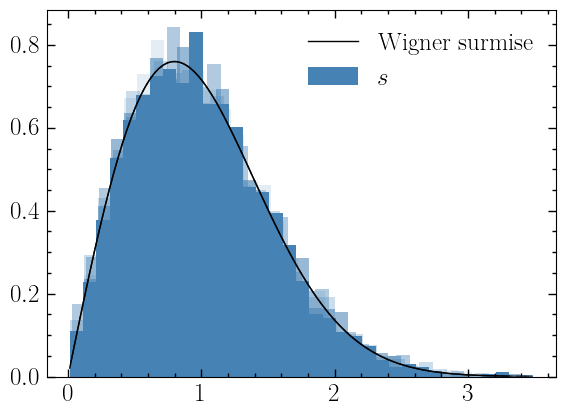

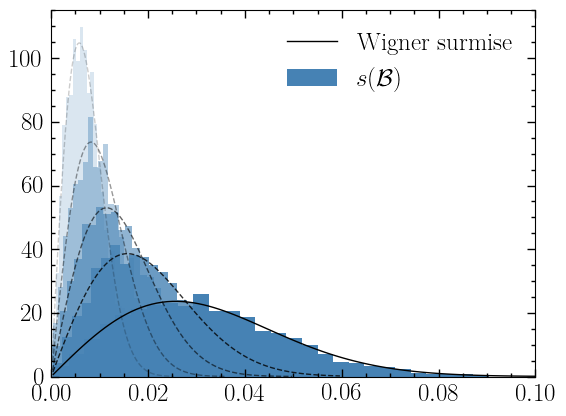

In [30]:
# Wigner surmise

n_d = len(eig_hist_bs)
dx_wig_bs = np.empty((n_d, num_split))
dx2_wig_bs = np.empty((n_d, num_split))

for i in range(len(eig_hist_bs)):
    for idx in range(finflag[0], finflag[1], finflag[2]):
        lbd_ens = eig_hist_bs[i,:,-1,idx:idx+2]
        kap = eig_phi[idx]
        print(np.round(np.mean(lbd_ens),3), np.round(kap,3))
        
        ##
        s_ens2 = np.abs(lbd_ens[:,0] - lbd_ens[:,1])**2

        y = s_ens2
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean2 = np.sum(px * hb)/np.sum(hb)
        dx2_wig_bs[i][idx//2] = s_mean2
        ##

        s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

        y = s_ens
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean = np.sum(px * hb)/np.sum(hb)
        s_mean2 = np.sum(px * hb**2)/np.sum(hb)
        dx_wig_bs[i][idx//2] = s_mean
        dx2_wig_bs[i][idx//2] = s_mean2
        print('bs:', bss[i], 's:', s_mean)

        yp = y / s_mean

        n_bins, xran = f_bin(yp)
        x = np.linspace(xran[0], xran[1], 100)

        def wigner(x):
            return 0.5*np.pi*x*np.exp(-np.pi * 0.25 * (x)**2)

        if i == 0:
            plt.plot(x, wigner(x), c='k', label=r'Wigner surmise')
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue',
                     label=r'$s$')
        else:
            plt.plot(x, wigner(x), c='k', ls='--', alpha=0.7*i/n_d)
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue', alpha=0.7*i/n_d)
    
plt.legend()
    
plt.tight_layout()

plt.savefig(plot_dir+'wigner_bs.pdf')
plt.show()

# Wigner surmise

n_d = len(eig_hist_bs)
for i in range(len(eig_hist_bs)):
    for idx in range(finflag[0], finflag[1], finflag[2]):
        lbd_ens = eig_hist_bs[i,:,-1,idx:idx+2]

        s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

        y = s_ens
        n_bins, xran = f_bin(y)
        x = np.linspace(xran[0], xran[1], 100)

        hb, pb = np.histogram(y, range=xran,
                              bins=n_bins, density=True)

        px = np.empty_like(hb)
        for j in range(len(px)):
            px[j] = 0.5*(pb[j] + pb[j+1])

        s_mean = np.sum(px * hb)/np.sum(hb)

        yp = y

        def wigner(x):
            return 0.5*np.pi*(x/s_mean**2)*np.exp(-np.pi * 0.25 * (x/s_mean)**2)

        n_bins, xran = f_bin(yp)
        x = np.linspace(xran[0], xran[1], 100)

        if i == 0:
            plt.plot(x, wigner(x), c='k', ls='-', label=r'Wigner surmise')
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue',
                     label=r'$s(\mathcal{B})$')
        else:
            plt.plot(x, wigner(x), c='k', ls='--', alpha=(n_d-i)/n_d)
            plt.hist(yp, bins=n_bins, range=xran, density=True, color='steelblue', alpha=(n_d-i)/n_d)

        plt.xlim(0,0.1)
    
plt.legend()
    
plt.tight_layout()

plt.savefig(plot_dir+'wigner_unscaled_bs.pdf')
plt.show()


# JackKnife

In [31]:
if load_data:
    dx_wig_jk_n = full_data['dx_n_jk']
else:
    dx_wig_jk_n = np.empty((len(ns), n_seed, num_split))
    for k in range(len(ns)):
        print(ns[k])

        for idx in range(finflag[0], finflag[1], 2):

            lbd_ens = eig_hist_n[k,:,-1,idx:idx+2]

            s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

            y_jk = np.empty((len(s_ens), len(s_ens)-1))
            for jk in range(len(s_ens)):
                y_jk[jk] = np.r_[s_ens[:jk],s_ens[jk+1:]]

            print(np.mean(y_jk), np.mean(s_ens))

            for jk in range(len(y_jk)):
                n_bins, xran = f_bin(y_jk[jk])

                hb, pb = np.histogram(y_jk[jk], range=xran,
                                      bins=n_bins, density=True)

                px = np.empty_like(hb)
                for i in range(len(px)):
                    px[i] = 0.5*(pb[i] + pb[i+1])

                s_mean = np.sum(px * hb)/np.sum(hb)
                dx_wig_jk_n[k][jk][idx//2]= s_mean

if load_data:
    dx_wig_jk_lr = full_data['dx_lr_jk']
else:
    dx_wig_jk_lr = np.empty((len(lrs), n_seed, num_split))
    for k in range(len(res_lr)):
        print(lrs[k])

        for idx in range(finflag[0], finflag[1], 2):

            lbd_ens = eig_hist_lr[k,:,-1,idx:idx+2]

            s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

            y_jk = np.empty((len(s_ens), len(s_ens)-1))
            for jk in range(len(s_ens)):
                y_jk[jk] = np.r_[s_ens[:jk],s_ens[jk+1:]]

            print(np.mean(y_jk), np.mean(s_ens))

            for jk in range(len(y_jk)):
                n_bins, xran = f_bin(y_jk[jk])

                hb, pb = np.histogram(y_jk[jk], range=xran,
                                      bins=n_bins, density=True)

                px = np.empty_like(hb)
                for i in range(len(px)):
                    px[i] = 0.5*(pb[i] + pb[i+1])

                s_mean = np.sum(px * hb)/np.sum(hb)
                dx_wig_jk_lr[k][jk][idx//2]= s_mean
                        
if load_data:
    dx_wig_jk_bs = full_data['dx_bs_jk']
else:
    dx_wig_jk_bs = np.empty((len(bss), n_seed, num_split))
    for k in range(len(res_bs)):
        print(bss[k])

        for idx in range(finflag[0], finflag[1], 2):

            lbd_ens = eig_hist_bs[k,:,-1,idx:idx+2]

            s_ens = np.abs(lbd_ens[:,0] - lbd_ens[:,1])

            y_jk = np.empty((len(s_ens), len(s_ens)-1))
            for jk in range(len(s_ens)):
                y_jk[jk] = np.r_[s_ens[:jk],s_ens[jk+1:]]

            print(np.mean(y_jk), np.mean(s_ens))

            for jk in range(len(y_jk)):
                n_bins, xran = f_bin(y_jk[jk])

                hb, pb = np.histogram(y_jk[jk], range=xran,
                                      bins=n_bins, density=True)

                px = np.empty_like(hb)
                for i in range(len(px)):
                    px[i] = 0.5*(pb[i] + pb[i+1])

                s_mean = np.sum(px * hb)/np.sum(hb)
                dx_wig_jk_bs[k][jk][idx//2]= s_mean

f 3000
(16,) (16,)
[1.87849797] [[0.00114492]]
(16,)
0.01691430423562385


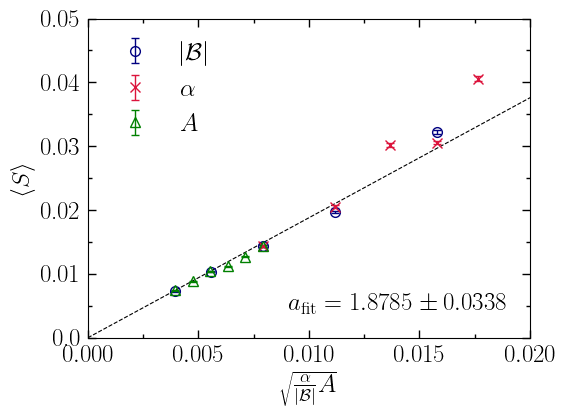

In [32]:
dx_pred_n1 = np.array([np.sqrt(fixed_lr*np.abs((x**2))/fixed_bs) for x in ns])
dx_pred_n1 = np.tile(dx_pred_n1,(num_split,1)).T.flatten()

dx_pred_lr1 = np.array([np.sqrt(x*np.abs((fixed_noise**2))/fixed_bs) for x in lrs])
dx_pred_lr1 = np.tile(dx_pred_lr1,(num_split,1)).T.flatten()

dx_pred_bs1 = np.array([np.sqrt(fixed_lr*np.abs((fixed_noise**2))/x) for x in bss])
dx_pred_bs1 = np.tile(dx_pred_bs1,(num_split,1)).T.flatten()

dx_mean_two_n = np.mean(dx_wig_jk_n, axis=1).flatten()
dx_std_two_n = (np.std(dx_wig_jk_n, axis=1)*np.sqrt(dx_wig_jk_n.shape[1] - 1)).flatten()

dx_mean_two_lr = np.mean(dx_wig_jk_lr, axis=1).flatten()
dx_std_two_lr = (np.std(dx_wig_jk_lr, axis=1)*np.sqrt(dx_wig_jk_lr.shape[1] - 1)).flatten()

dx_mean_two_bs = np.mean(dx_wig_jk_bs, axis=1).flatten()
print('f',dx_wig_jk_bs.shape[1])
dx_std_two_bs = (np.std(dx_wig_jk_bs, axis=1)*np.sqrt(dx_wig_jk_bs.shape[1] - 1)).flatten()

def lin_fit(x, a):
    return a*x

x = np.r_[dx_pred_n1, dx_pred_lr1, dx_pred_bs1]
y = np.r_[dx_mean_two_n, dx_mean_two_lr, dx_mean_two_bs]
err = np.r_[dx_std_two_n, dx_std_two_lr, dx_std_two_bs]
print(x.shape, y.shape)
popt, pcov = sp.optimize.curve_fit(lin_fit,
                                   xdata=x,
                                   ydata=y,
                                   sigma=err)
print(popt,pcov)

print(err.shape)
r = (y - lin_fit(x,*popt))
sigma = np.linalg.inv(np.diag(err))
chisq = r.T @ sigma @ r
dof = len(x) - 1.
print(chisq/dof)

xmax = 0.08
x = np.linspace(0, xmax,100)
plt.plot(x, lin_fit(x,*popt), 'k--', lw=0.8,)

plt.errorbar(dx_pred_bs1, dx_mean_two_bs, 
             c='navy', marker='o', ls='', 
             yerr=dx_std_two_bs, label=r'$|\mathcal{B}|$')
plt.errorbar(dx_pred_lr1, dx_mean_two_lr, 
             c='crimson', marker='x', ls='', 
             yerr=dx_std_two_lr, label=r'$\alpha$')
plt.errorbar(dx_pred_n1, dx_mean_two_n, 
             c='green', marker='^', ls='', 
             yerr=dx_std_two_n, label=r'$A$')


plt.plot()
plt.xlabel(r'$\sqrt{\frac{\alpha}{|\mathcal{B}|} A}$')
plt.ylabel(r'$\langle S \rangle$')
 
ytik = np.round(np.arange(0,0.1,0.01),2)
plt.yticks(ytik,ytik)

plt.text(0.95,0.14,
         transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='top',
         s=r"$a_{\rm fit} = %.4f \pm %.4f$"%(popt[0], np.sqrt(pcov[0,0])))

plt.xlim(0, 0.02)
plt.ylim(0, 0.05)

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig(plot_dir+'TS-pred_comp-all_wig-fit.pdf')
plt.show()

# spectral density

In [33]:
def rho(x, x0, sig):
    A = np.exp(-(x - x0)**2 / (2.*sig**2))/(4.*np.sqrt(np.pi)*sig)
    B = 2.*np.exp(-(x - x0)**2 / (2.*sig**2))
    C = np.sqrt(2.*np.pi) * (x - x0) * sp.special.erf((x-x0)/(np.sqrt(2)*sig)) / sig
    return A * (B + C)

In [34]:
if load_data:
    sig_list_two_jk_n = full_data['sig_n_jk']
else:

    x0_list_two_jk_n = np.empty((len(ns), n_seed*2, num_split))
    sig_list_two_jk_n = np.empty((len(ns), n_seed*2, num_split))
    sig_err_list_two_jk_n = np.empty((len(ns), n_seed*2, num_split))
    sigp_list_two_n = np.empty((len(ns)))

    for idx in range(finflag[0], finflag[1], finflag[2]):
        for k in range(len(res_n)):
            print('n:', ns[k])
            kap = eig_phi[idx]

            print('kap:',kap)
            y = eig_hist_n[k][:,-1,idx:idx+2].flatten()
            print('y:',np.mean(y))

            sig_pred = np.sqrt(fixed_lr * ns[k]**2 / fixed_bs)
            sigp_list_two_n[k] = sig_pred

            y_jk = np.empty((len(y), len(y)-1))
            for jk in range(len(y)):
                y_jk[jk] = np.r_[y[:jk],y[jk+1:]]

            print(np.mean(y_jk), np.mean(y))

            for jk in range(len(y)):
                n_bins, xran = f_bin(y_jk[jk])

                hb, pb = np.histogram(y_jk[jk], range=xran,
                                      bins=n_bins, density=True)

                px = np.empty_like(hb)
                for i in range(len(px)):
                    px[i] = 0.5*(pb[i] + pb[i+1])

                popt, pcov = curve_fit(rho, px, hb, \
                                       p0=[kap, sig_pred])
                
                dx = np.abs(popt[1])

                x0_list_two_jk_n[k][jk][idx//2] = popt[0]
                sig_list_two_jk_n[k][jk][idx//2] = dx
                sig_err_list_two_jk_n[k][jk][idx//2] = pcov[1,1]

            print(np.mean(sig_err_list_two_jk_n[k], axis=0))
            print(np.mean(sig_list_two_jk_n[k], axis=0))
            print(sigp_list_two_n[k])

In [35]:
if not load_data:   
    for idx in range(finflag[0], finflag[1], finflag[2]):
        for k in range(len(res_n)):
            print('n:', ns[k])
            kap = eig_phi[idx]
            print('kap:',kap)

            y = eig_hist_n[k][:,-1,idx:idx+2].flatten()
            print('y:',np.mean(y))
            n_bins, xran = f_bin(y)
            hb, bi, _ =plt.hist(y, alpha=0.8, range=xran,
                     bins=n_bins, density=True, color='steelblue')

            xxran = (np.max(xran)-kap)
            x = np.linspace(kap-xxran, kap+xxran,100)

            x0 = np.mean(x0_list_two_jk_n[k,:,idx//2])
            sig0 = np.mean(sig_list_two_jk_n[k,:,idx//2])

            plt.plot(x, rho(x, x0, sig0), c='k', ls=ls_[0],
                     label=r"$\rho(%.2f,%.4f)$"%(x0, sig0))


            ymax = np.max(hb)
            plt.text(kap+xxran*0.45,ymax-0.06*ymax,r"$\sigma_{pred} = %.4f$"%(sigp_list_two_n[k]))


            plt.axvline(kap, 0, 0.8, c='navy', ls=ls_[2],)

            plt.legend(loc='upper left')
            plt.tight_layout()
            plt.savefig(plot_dir+'rhofit%d_n%.1f.pdf'%(idx, ns[k]))
            plt.show()

In [36]:
if load_data:
    sig_list_two_jk_lr = full_data['sig_lr_jk']
else:
    x0_list_two_jk_lr = np.empty((len(lrs), n_seed*2, num_split))
    sig_list_two_jk_lr = np.empty((len(lrs), n_seed*2, num_split))
    sig_err_list_two_jk_lr = np.empty((len(lrs), n_seed*2, num_split))
    sigp_list_two_lr = np.empty((len(lrs)))

    for idx in range(finflag[0], finflag[1], 2):
        for k in range(len(res_lr)):
            print('n:', lrs[k])
            kap = eig_phi[idx]

            print('kap:',kap)
            y = eig_hist_lr[k][:,-1,idx:idx+2].flatten()
            print('y:',np.mean(y))

            sig_pred = np.sqrt(lrs[k] * fixed_noise**2 / fixed_bs)
            sigp_list_two_lr[k] = sig_pred

            y_jk = np.empty((len(y), len(y)-1))
            for jk in range(len(y)):
                y_jk[jk] = np.r_[y[:jk],y[jk+1:]]

            print(np.mean(y_jk), np.mean(y))

            for jk in range(len(y)):
                n_bins, xran = f_bin(y_jk[jk])

                hb, pb = np.histogram(y_jk[jk], range=xran,
                                      bins=n_bins, density=True)

                px = np.empty_like(hb)
                for i in range(len(px)):
                    px[i] = 0.5*(pb[i] + pb[i+1])

                popt, pcov = curve_fit(rho, px, hb, \
                                       p0=[kap, sig_pred])
                dx = np.abs(popt[1])

                x0_list_two_jk_lr[k][jk][idx//2] = popt[0]
                sig_list_two_jk_lr[k][jk][idx//2] = dx
                sig_err_list_two_jk_lr[k][jk][idx//2] = pcov[1,1]

            print(np.mean(sig_err_list_two_jk_lr[k], axis=0))
            print(np.mean(sig_list_two_jk_lr[k], axis=0))
            print(sigp_list_two_lr[k])

In [37]:
if not load_data:
    for idx in range(finflag[0], finflag[1], 2):
        for k in range(len(res_lr)):
            print('n:', lrs[k])
            kap = eig_phi[idx]
            print('kap:',kap)

            y = eig_hist_lr[k][:,-1,idx:idx+2].flatten()
            print('y:',np.mean(y))
            n_bins, xran = f_bin(y)
            hb, bi, _ =plt.hist(y, alpha=0.8, range=xran,
                     bins=n_bins, density=True, color='steelblue')

            xxran = (np.max(xran)-kap)
            x = np.linspace(kap-xxran, kap+xxran,100)

            x0 = np.mean(x0_list_two_jk_lr[k,:,idx//2])
            sig0 = np.mean(sig_list_two_jk_lr[k,:,idx//2])

            plt.plot(x, rho(x, x0, sig0), c='k', ls=ls_[0],
                     label=r"$\rho(%.2f,%.4f)$"%(x0, sig0))


            ymax = np.max(hb)
            plt.text(kap+xxran*0.45,ymax-0.06*ymax,r"$\sigma_{pred} = %.4f$"%(sigp_list_two_lr[k]))


            plt.axvline(kap, 0, 0.8, c='navy', ls=ls_[2],)

            plt.legend(loc='upper left')
            plt.tight_layout()
            plt.savefig(plot_dir+'rhofit%d_lr%.2f.pdf'%(idx, lrs[k]))
            plt.show()

In [38]:
if load_data:
    sig_list_two_jk_bs = full_data['sig_bs_jk']
else:

    x0_list_two_jk_bs = np.empty((len(bss), n_seed*2, num_split))
    sig_list_two_jk_bs = np.empty((len(bss), n_seed*2, num_split))
    sig_err_list_two_jk_bs = np.empty((len(bss), n_seed*2, num_split))
    sigp_list_two_bs = np.empty((len(bss)))

    for idx in range(finflag[0], finflag[1], finflag[2]):
        for k in range(len(res_bs)):
            print('n:', bss[k])
            kap = eig_phi[idx]

            print('kap:',kap)
            y = eig_hist_bs[k][:,-1,idx:idx+2].flatten()
            print('y:', np.mean(y))

            sig_pred = np.sqrt(fixed_lr * fixed_noise**2 / bss[k])
            sigp_list_two_bs[k] = sig_pred

            y_jk = np.empty((len(y), len(y)-1))
            for jk in range(len(y)):
                y_jk[jk] = np.r_[y[:jk],y[jk+1:]]

            print(np.mean(y_jk), np.mean(y))

            for jk in range(len(y)):
                n_bins, xran = f_bin(y_jk[jk])

                hb, pb = np.histogram(y_jk[jk], range=xran,
                                      bins=n_bins, density=True)

                px = np.empty_like(hb)
                for i in range(len(px)):
                    px[i] = 0.5*(pb[i] + pb[i+1])

                popt, pcov = curve_fit(rho, px, hb, \
                                       p0=[kap, sig_pred])
                
                dx = np.abs(popt[1])

                x0_list_two_jk_bs[k][jk][idx//2] = popt[0]
                sig_list_two_jk_bs[k][jk][idx//2] = dx
                sig_err_list_two_jk_bs[k][jk][idx//2] = pcov[1,1]

            print(np.mean(sig_err_list_two_jk_bs[k], axis=0))
            print(np.mean(sig_list_two_jk_bs[k], axis=0))
            print(sigp_list_two_bs[k])

In [39]:
if not load_data:
    for idx in range(finflag[0], finflag[1], finflag[2]):
        for k in range(len(res_bs)):
            print('n:', bss[k])
            kap = eig_phi[idx]
            print('kap:',kap)

            y = eig_hist_bs[k][:,-1,idx:idx+2].flatten()
            print('y:',np.mean(y))
            n_bins, xran = f_bin(y)
            hb, bi, _ =plt.hist(y, alpha=0.8, range=xran,
                     bins=n_bins, density=True, color='steelblue')

            xxran = (np.max(xran)-kap)
            x = np.linspace(kap-xxran, kap+xxran,100)

            x0 = np.mean(x0_list_two_jk_bs[k,:,idx//2])
            sig0 = np.mean(sig_list_two_jk_bs[k,:,idx//2])

            plt.plot(x, rho(x, x0, sig0), c='k', ls=ls_[0],
                     label=r"$\rho(%.2f,%.4f)$"%(x0, sig0))


            ymax = np.max(hb)
            plt.text(kap+xxran*0.45,ymax-0.06*ymax,r"$\sigma_{pred} = %.4f$"%(sigp_list_two_bs[k]))


            plt.axvline(kap, 0, 0.8, c='navy', ls=ls_[2],)

            plt.legend(loc='upper left')
            plt.tight_layout()
            plt.savefig(plot_dir+'rhofit%d_bs%2d.pdf'%(idx, bss[k]))
            plt.show()

(16,) (16,)
[1.87107575]
[0.03355837]
0.026564016879335385


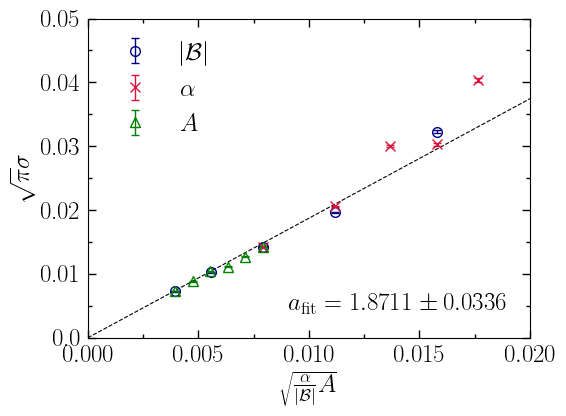

In [40]:
sig_pred_n1 = np.array([np.sqrt(fixed_lr*np.abs((x**2))/fixed_bs) for x in ns])
sig_pred_n1 = np.tile(sig_pred_n1,(num_split,1)).T.flatten()

sig_pred_lr1 = np.array([np.sqrt(x*np.abs((fixed_noise**2))/fixed_bs) for x in lrs])
sig_pred_lr1 = np.tile(sig_pred_lr1,(num_split,1)).T.flatten()

sig_pred_bs1 = np.array([np.sqrt(fixed_lr*np.abs((fixed_noise**2))/x) for x in bss])
sig_pred_bs1 = np.tile(sig_pred_bs1,(num_split,1)).T.flatten()

sig_mean_two_n = np.mean(sig_list_two_jk_n, axis=1).flatten()
sig_std_two_n = (np.std(sig_list_two_jk_n, axis=1)*np.sqrt(sig_list_two_jk_n.shape[1] - 1)).flatten()

sig_mean_two_lr = np.mean(sig_list_two_jk_lr, axis=1).flatten()
sig_std_two_lr = (np.std(sig_list_two_jk_lr, axis=1)*np.sqrt(sig_list_two_jk_lr.shape[1] - 1)).flatten()

sig_mean_two_bs = np.mean(sig_list_two_jk_bs, axis=1).flatten()
sig_std_two_bs = (np.std(sig_list_two_jk_bs, axis=1)*np.sqrt(sig_list_two_jk_bs.shape[1] - 1)).flatten()

def lin_fit(x, a):
    return a*x

x = np.r_[sig_pred_n1, sig_pred_lr1, sig_pred_bs1]
y = np.sqrt(np.pi)*np.r_[sig_mean_two_n, sig_mean_two_lr, sig_mean_two_bs]
err = np.r_[sig_std_two_n, sig_std_two_lr, sig_std_two_bs]
print(x.shape, y.shape)

popt, pcov = sp.optimize.curve_fit(lin_fit,
                                   xdata=x,
                                   ydata=y,
                                   sigma=err,)
print(popt)
print(np.sqrt(np.diag(pcov)))

r = (y - lin_fit(x,*popt))
sigma = np.linalg.inv(np.diag(err))
chisq = r.T @ sigma @ r
dof = len(x) - 1.
print(chisq/dof)

xmax = 0.05
x = np.linspace(0, xmax,100)
plt.plot(x, lin_fit(x,*popt), 'k--', lw=0.8,)

plt.errorbar(sig_pred_bs1, np.sqrt(np.pi) *sig_mean_two_bs, 
             c='navy', marker='o', ls='', 
             yerr=sig_std_two_bs, label=r'$|\mathcal{B}|$')

plt.errorbar(sig_pred_lr1, np.sqrt(np.pi) *sig_mean_two_lr, 
             c='crimson', marker='x', ls='', 
             yerr=sig_std_two_lr, label=r'$\alpha$')

plt.errorbar(sig_pred_n1, np.sqrt(np.pi) *sig_mean_two_n, 
             c='green', marker='^', ls='', 
             yerr=sig_std_two_n, label=r'$A$')

plt.xlabel(r'$\sqrt{\frac{\alpha}{|\mathcal{B}|} A}$')
plt.ylabel(r'$\sqrt{\pi} \sigma$')
    
tik = np.round(np.arange(0,0.1,0.01),2)
plt.yticks(tik,tik)

plt.text(0.95,0.14,
         transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='top',
         s=r"$a_{\rm fit} = %.4f \pm %.4f$"%(popt[0], np.sqrt(pcov[0,0])))

plt.xlim(0,0.02)
plt.ylim(0,0.05)

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig(plot_dir+'TS-pred_comp-all_sig-fit.pdf')
plt.show()

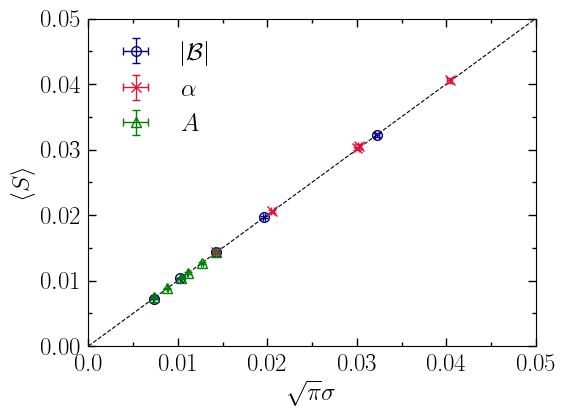

In [41]:
sqpi = np.sqrt(np.pi)

plt.plot([0.0,0.3],[0.0,0.3],'k--', lw=0.8)

plt.errorbar(sqpi*sig_mean_two_bs.flatten(), dx_mean_two_bs.flatten(),
             c='navy', marker='o', ls='', 
             xerr=sig_std_two_bs.flatten(), 
             yerr=dx_std_two_bs.flatten(),
             label=r'$|\mathcal{B}|$')

plt.errorbar(sqpi*sig_mean_two_lr.flatten(), dx_mean_two_lr.flatten(),
             c='crimson', marker='x', ls='', 
             xerr=sig_std_two_lr.flatten(), 
             yerr=dx_std_two_lr.flatten(),
             label=r'$\alpha$')

plt.errorbar(sqpi*sig_mean_two_n.flatten(), dx_mean_two_n.flatten(), 
             c='green', marker='^', ls='', 
             xerr=sig_std_two_n.flatten(),
             yerr=dx_std_two_n.flatten(),
             label=r'$A$')


plt.plot()
plt.xlabel(r'$\sqrt{\pi} \sigma$')
plt.ylabel(r'$\langle S \rangle$')
    
tik = np.round(np.arange(0,0.1,0.01),2)
plt.xticks(tik,tik)

plt.xlim(0,0.05)
plt.ylim(0,0.05)

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig(plot_dir+'sig-S.pdf')
plt.show()

S from Wigner semicircle  
sig from spectral density

In [42]:
np.savez(data_dir+'/'+project_name+'.npz',
         lr=eig_hist_lr, bs=eig_hist_bs, ns=eig_hist_n,
         dx_n_jk=dx_wig_jk_n, dx_lr_jk=dx_wig_jk_lr, dx_bs_jk=dx_wig_jk_bs, 
         sig_n_jk=sig_list_two_jk_n, sig_lr_jk=sig_list_two_jk_lr, sig_bs_jk=sig_list_two_jk_bs)
print("Full data saved:", data_dir+'/'+project_name+'.npz')

Full data saved: ../data/TSmodel//TSmodel.npz
